In [1]:
import pydicom
import os
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import wandb

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, random_split

from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

#### Unzip files

In [55]:
def unzip_files(directory, unzipped_scans):
    if not os.path.exists(unzipped_scans):
        os.makedirs(unzipped_scans)

    for item in os.listdir(directory):
        if item.endswith('.zip'):
            file_path = os.path.join(directory, item)
            try:
                with zipfile.ZipFile(file_path, 'r') as zip_ref:
                    zip_ref.extractall(unzipped_scans)
                    print(f"Unzipped {item}")
            except zipfile.BadZipFile:
                print(f"Skipped {item}: Not a valid ZIP file")

In [59]:
unzip_files("rawData","D:\Personal\Ona bby\MLPR LABS\pythonProject1\data_unzipped")

Unzipped CQ500-CT-0.zip
Unzipped CQ500-CT-1.zip
Unzipped CQ500-CT-10.zip
Unzipped CQ500-CT-100.zip
Unzipped CQ500-CT-101.zip
Unzipped CQ500-CT-102.zip
Unzipped CQ500-CT-103.zip
Unzipped CQ500-CT-104.zip
Unzipped CQ500-CT-105.zip
Unzipped CQ500-CT-106.zip
Unzipped CQ500-CT-107.zip
Unzipped CQ500-CT-108.zip
Unzipped CQ500-CT-109.zip
Unzipped CQ500-CT-11.zip
Unzipped CQ500-CT-110.zip
Unzipped CQ500-CT-111.zip
Unzipped CQ500-CT-112.zip
Unzipped CQ500-CT-114.zip
Unzipped CQ500-CT-115.zip
Unzipped CQ500-CT-116.zip
Unzipped CQ500-CT-117.zip
Unzipped CQ500-CT-118.zip
Unzipped CQ500-CT-119.zip
Unzipped CQ500-CT-12.zip
Skipped CQ500-CT-120.zip: Not a valid ZIP file
Unzipped CQ500-CT-121.zip
Unzipped CQ500-CT-122.zip
Unzipped CQ500-CT-123.zip
Unzipped CQ500-CT-124.zip
Unzipped CQ500-CT-125.zip
Unzipped CQ500-CT-126.zip
Unzipped CQ500-CT-127.zip
Unzipped CQ500-CT-128.zip
Unzipped CQ500-CT-129.zip
Unzipped CQ500-CT-13.zip
Unzipped CQ500-CT-130.zip
Unzipped CQ500-CT-131.zip
Unzipped CQ500-CT-132.zip

#### Sample Data Preprocessing for visualisation

In [65]:
# Full path of the DICOM file is passed in base 
base = "unzipped_scans/CQ500CT1 CQ500CT1/Unknown Study"

loaded_files = []
for root, dirs, files in os.walk(base):
    if not dirs:
        for file in files:
            if file.lower().endswith(".dcm"):
                file_path = os.path.join(root, file)
                try:
                    dicom_file = pydicom.dcmread(file_path)
                    loaded_files.append(dicom_file)
                except Exception as e:
                    print(f"Error loading DICOM file {file_path}: {e}")

slope = dicom_file.RescaleSlope
intercept = dicom_file.RescaleIntercept

slices = []
skipcount = 0
for f in loaded_files:
    if hasattr(f, "SliceLocation"):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print(f"skipped, no SliceLocation: {skipcount}")

# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)


# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    for j in range(img2d.shape[0]):
        for k in range(img2d.shape[1]):
            img2d[j][k] = slope*img2d[j][k] + intercept
            if(img2d[j][k]<0):
                img2d[j][k] = 0
            if img2d[j][k]>100:
                img2d[j][k] = 100
    img3d[:, :, i] = img2d

# plot 3 orthogonal slices
plt.imshow(img3d[:, :, 17], cmap='gray')
plt.axis("off")
print(img3d.shape)
plt.show()

# for i in range(img3d.shape[2]):
#     slice_path = os.path.join("Processed_sample", f"slice_{i:03d}.png")  # Zero-padded filenames
#     plt.imsave(slice_path, img3d[:, :, i], cmap='gray')


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 78-79: truncated \UXXXXXXXX escape (2018657002.py, line 3)

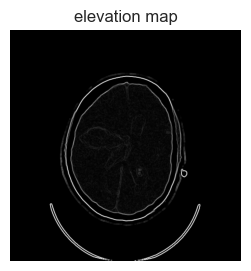

In [33]:
from skimage.filters import sobel
from skimage import exposure
im = img3d[:,:,19]
elevation_map = sobel(im)
fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(elevation_map, cmap=plt.cm.gray)
ax.set_title('elevation map')
ax.set_axis_off()

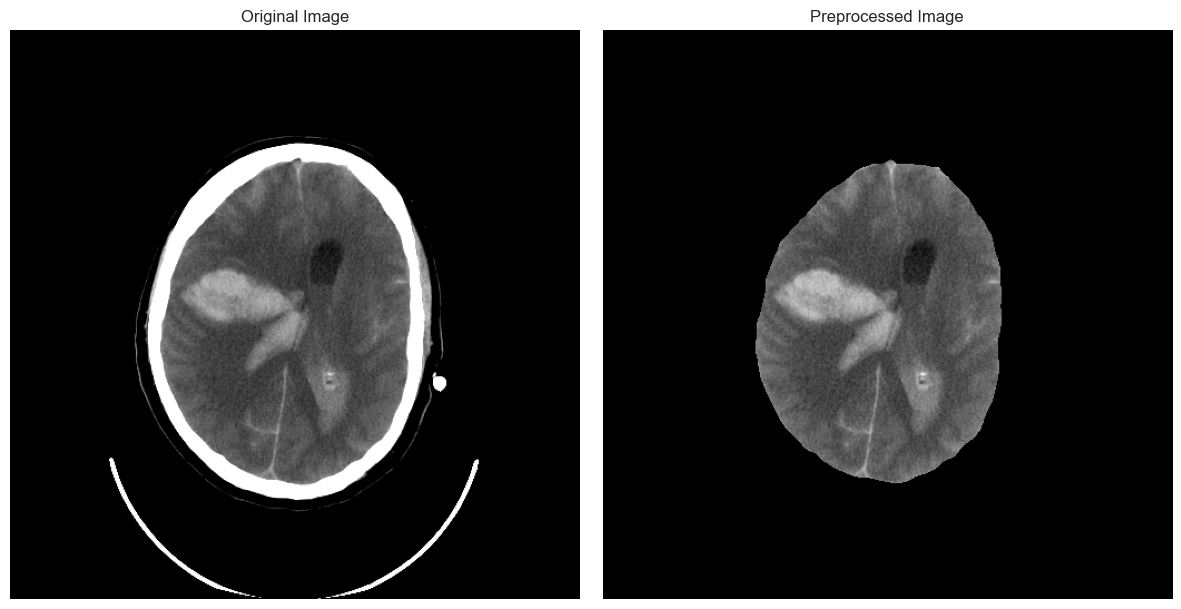

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import closing, erosion, disk
from skimage.measure import label, regionprops
from scipy.ndimage import binary_fill_holes

# Assume `im` is the input image after windowing
imax = 100
imin = 0

# Step 1: Create removal mask for tissues with intensity == imax
removal_mask = im == imax

# Step 2: Apply morphological closing to fill small gaps
closed_mask = closing(removal_mask, disk(3))  # Disk size can be adjusted

# Step 3: Set regions covered by the mask to imin
preprocessed_im = im.copy()
preprocessed_im[closed_mask] = imin

# Step 4: Identify the largest contiguous region (assumed to be the brain)
labeled_regions = label(preprocessed_im > imin)
regions = regionprops(labeled_regions)
if regions:
    largest_region = max(regions, key=lambda r: r.area)
    brain_mask = labeled_regions == largest_region.label
else:
    brain_mask = np.zeros_like(preprocessed_im, dtype=bool)

# Step 5: Remove regions not part of the brain by setting them to imin
preprocessed_im[~brain_mask] = imin

# Step 6: Apply morphological erosion to remove high-intensity edges
eroded_brain_mask = erosion(brain_mask, disk(2))  # Disk size can be adjusted
preprocessed_im[~eroded_brain_mask] = imin

# Plot the result
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(im, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(preprocessed_im, cmap='gray')
ax[1].set_title('Preprocessed Image')
ax[1].axis('off')

plt.tight_layout()
plt.show()


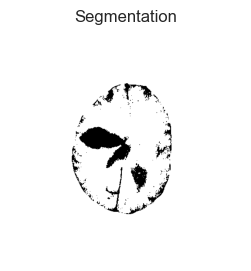

In [41]:
markers = np.zeros_like(preprocessed_im)
markers[preprocessed_im > 20] = 1
markers[preprocessed_im < 40] = 2

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(markers, cmap="gray")
ax.set_title('Segmentation')
ax.set_axis_off()

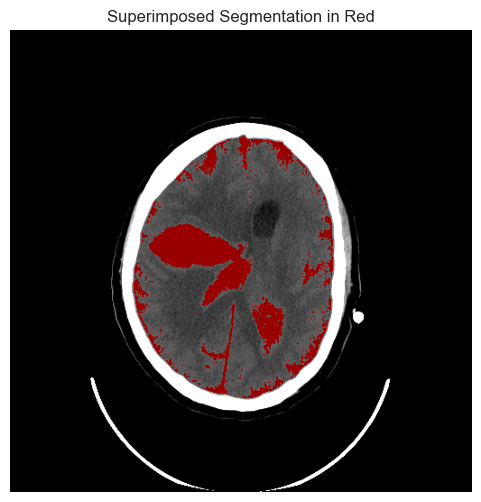

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Convert grayscale image to RGB
im_rgb = np.stack([im, im, im], axis=-1)  # Shape: (H, W, 3)

# Normalize the image to [0, 1] for visualization
im_rgb = im_rgb / im_rgb.max()

# Create a red overlay for the segmented regions
overlay = np.zeros_like(im_rgb)  # Shape: (H, W, 3)
overlay[..., 0] = 0.6  # Set the red channel to maximum intensity

# Create a mask for the segmented regions
mask = markers == 1  # Modify as needed for specific regions

# Superimpose the red overlay
im_superimposed = im_rgb.copy()
im_superimposed[mask] = overlay[mask]

# Plot the result
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(im_superimposed)
ax.set_title('Superimposed Segmentation in Red')
ax.set_axis_off()
plt.show()


#### Full Data Preprocessing

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel
from skimage.morphology import closing, erosion, disk
from skimage.measure import label, regionprops
import pydicom

def preprocess_and_save(scan_dir, output_dir, imax=100, imin=0):
    """
    Preprocess all DICOM files in the scan directory and save the preprocessed images
    with the same directory structure in the output directory.
    The images are saved as PNG files.
    """
    for root, _, files in os.walk(scan_dir):
        relative_path = os.path.relpath(root, scan_dir)
        save_dir = os.path.join(output_dir, relative_path)
        os.makedirs(save_dir, exist_ok=True)

        for file in files:
            if file.lower().endswith(".dcm"):
                file_path = os.path.join(root, file)
                try:
                    # Read the DICOM file
                    dicom_file = pydicom.dcmread(file_path)
                    im = dicom_file.pixel_array
                    slope = getattr(dicom_file, "RescaleSlope", 1)
                    intercept = getattr(dicom_file, "RescaleIntercept", 0)
                    im = im * slope + intercept

                    # Clip intensity to [0, imax]
                    im = np.clip(im, 0, imax)

                    # Step 1: Create removal mask for tissues with intensity == imax
                    removal_mask = im == imax

                    # Step 2: Apply morphological closing to fill small gaps
                    closed_mask = closing(removal_mask, disk(3))

                    # Step 3: Set regions covered by the mask to imin
                    preprocessed_im = im.copy()
                    preprocessed_im[closed_mask] = imin

                    # Step 4: Identify the largest contiguous region (assumed to be the brain)
                    labeled_regions = label(preprocessed_im > imin)
                    regions = regionprops(labeled_regions)
                    if regions:
                        largest_region = max(regions, key=lambda r: r.area)
                        brain_mask = labeled_regions == largest_region.label
                    else:
                        brain_mask = np.zeros_like(preprocessed_im, dtype=bool)

                    # Step 5: Remove regions not part of the brain by setting them to imin
                    preprocessed_im[~brain_mask] = imin

                    # Step 6: Apply morphological erosion to remove high-intensity edges
                    eroded_brain_mask = erosion(brain_mask, disk(2))
                    preprocessed_im[~eroded_brain_mask] = imin
                    
                    #Segmentation
                    markers = np.zeros_like(preprocessed_im)
                    markers[preprocessed_im > 20] = 1
                    markers[preprocessed_im < 50] = 2

                    #overlay
                    # Convert grayscale image to RGB
                    im_rgb = np.stack([im, im, im], axis=-1)  # Shape: (H, W, 3)

                    # Normalize the image to [0, 1] for visualization
                    im_rgb = im_rgb / im_rgb.max()

                    # Create a red overlay for the segmented regions
                    overlay = np.zeros_like(im_rgb)  # Shape: (H, W, 3)
                    overlay[..., 0] = 0.6  # Set the red channel to maximum intensity

                    # Create a mask for the segmented regions
                    mask = markers == 1  # Modify as needed for specific regions

                    # Superimpose the red overlay
                    im_superimposed = im_rgb.copy()
                    im_superimposed[mask] = overlay[mask]

                    # Save the final preprocessed image as PNG
                    save_path = os.path.join(save_dir, f"{os.path.splitext(file)[0]}.png")
                    plt.imsave(save_path, preprocessed_im, cmap='gray')

                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

# Example usage
scan_dir = "D:\Personal\Ona bby\MLPR LABS\pythonProject1\data_unzipped"
output_dir = "D:\Personal\Ona bby\MLPR LABS\pythonProject1\Processed_scans_noMask"
preprocess_and_save(scan_dir, output_dir)

#### Prepare Data loader

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    # transforms.RandomHorizontalFlip(p=0.3),
    # transforms.RandomRotation(degrees=30),
])

In [3]:
processed_scans_path = "D:\Personal\Ona bby\MLPR LABS\pythonProject1\Processed_scans"
dataset = ImageFolder(processed_scans_path, transform=train_transform)
train_dl = DataLoader(dataset, 35, shuffle=True)

In [4]:
import re
def extract_digits(folder_name):
    match = re.search(r'(\d+)$', folder_name)
    if match:
        return int(match.group(1))
    else:
        return None

class ScanDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the scans organized in subfolders.
            csv_file (string): Path to the CSV file with labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.labels_df = pd.read_csv(csv_file)
        self.transform = transform
        self.scans = []
        self.load_scans()

    def load_scans(self):
        target_size = (512, 512)
        for subdir, dirs, files in os.walk(self.root_dir):
            for folder in dirs:
                folder_path = os.path.join(subdir, folder)
                scan_id = extract_digits(folder)
                # print(f'Folder: {folder}, Scan ID: {scan_id}')
                if scan_id is not None:
                    self.labels_df['ScansNum'] = self.labels_df['ScansNum'].astype(int)
                    label_row = self.labels_df[self.labels_df['ScansNum'] == scan_id]
                    if not label_row.empty:
                        # Assuming all columns except the first are labels
                        labels = label_row.iloc[0, 1:].values  # Adjust as necessary to select the right columns
                        for file in os.listdir(folder_path):
                            if file.endswith('.png'):  # Adjust the file type as needed
                                file_path = os.path.join(folder_path, file)
                                image = Image.open(file_path)
                                if image.size == target_size:
                                    self.scans.append((file_path, labels))



    def __len__(self):
        return len(self.scans)

    def __getitem__(self, idx):
        image_path, labels = self.scans[idx]
        image = Image.open(image_path)
        image_array = np.array(image)  # Load the image as is, without conversion to RGB
        return  torch.tensor(image_array, dtype=torch.float), torch.tensor(labels, dtype=torch.float)
    # Convert labels to a tensor if they are not already in a suitable format



In [91]:
import pandas as pd
print("data start")
dataset = ScanDataset(root_dir= processed_scans_path, csv_file="weighted.csv")
print("data generated")
# Calculate split sizes
total_count = len(dataset)
train_count = int(0.8 * total_count)
test_count = total_count - train_count

# Perform random split
train_dataset, test_dataset = random_split(dataset, [train_count, test_count])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
for images, labels in train_loader:
    # Example processing step
    print(images.shape, labels.shape)
    break
    

data start
data generated
torch.Size([32, 512, 512, 4]) torch.Size([32, 6])


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Resnet

In [41]:
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer to have 1 input channel if using grayscale images
model.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.conv1 = model.conv1.to(device)  # Move the new conv1 layer to GPU

# Modify the fully connected output layer to match the number of classes (6 in this case)
model.fc = nn.Linear(model.fc.in_features, 6)
model.fc = model.fc.to(device)  # Move the new fc layer to GPU

# Move the entire model to the appropriate device (GPU or CPU)
model = model.to(device)

C:\Users\Admin\PycharmProjects\TestProject\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Admin\PycharmProjects\TestProject\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

NameError: name 'model' is not defined

Epoch [1/10], currBatch: 0/539, Loss: 0.6524
Epoch [1/10], currBatch: 1/539, Loss: 0.4507
Epoch [1/10], currBatch: 2/539, Loss: 0.3294
Epoch [1/10], currBatch: 3/539, Loss: 0.1987
Epoch [1/10], currBatch: 4/539, Loss: 0.1488
Epoch [1/10], currBatch: 5/539, Loss: 0.0851
Epoch [1/10], currBatch: 6/539, Loss: 0.1742
Epoch [1/10], currBatch: 7/539, Loss: 0.0782
Epoch [1/10], currBatch: 8/539, Loss: 0.0818
Epoch [1/10], currBatch: 9/539, Loss: 0.0774
Epoch [1/10], currBatch: 10/539, Loss: 0.1275
Epoch [1/10], currBatch: 11/539, Loss: 0.0160
Epoch [1/10], currBatch: 12/539, Loss: 0.0275
Epoch [1/10], currBatch: 13/539, Loss: 0.0682
Epoch [1/10], currBatch: 14/539, Loss: 0.0748
Epoch [1/10], currBatch: 15/539, Loss: 0.0678
Epoch [1/10], currBatch: 16/539, Loss: 0.0451
Epoch [1/10], currBatch: 17/539, Loss: 0.0315
Epoch [1/10], currBatch: 18/539, Loss: 0.0868
Epoch [1/10], currBatch: 19/539, Loss: 0.0928
Epoch [1/10], currBatch: 20/539, Loss: 0.0224
Epoch [1/10], currBatch: 21/539, Loss: 0.064

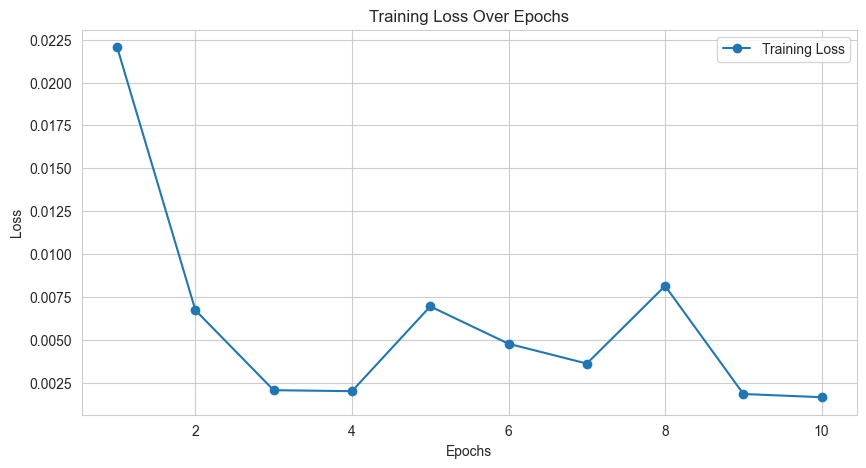

In [43]:
num_epochs = 10

train_loss_history = []  
for epoch in range(num_epochs):
    running_loss = 0.0
    for i,(images, labels) in enumerate(train_loader):
        images = images.to(device)
        images = images.permute(0, 3, 1, 2)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        wandb.log({"Loss": loss.item(), "Epoch": epoch+1})
        print(f'Epoch [{epoch+1}/{num_epochs}], currBatch: {i}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(train_loader)
    train_loss_history.append(epoch_loss) 
    torch.save(model.state_dict(), 'HeyCTModelDL_Seg.pth')
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}')

# Plotting the loss curve after training
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, marker='o', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
train_loss_history

[0.006813076244765877]

In [44]:
# Assuming sigmoid activation needed since you are using BCEWithLogitsLoss
model.eval()
total = 0
correct = 0

with torch.no_grad():
    for i,(images, labels) in enumerate(test_loader):
        images = images.to(device)
        images = images.permute(0, 3, 1, 2)
        labels = labels.to(device)

        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predicted = (outputs > 0.5).float()
        # print(predicted)
        loss = criterion(outputs, labels)

        # Correct calculation for binary accuracy in multi-label setting
        total += labels.numel()  # Total number of label entries
        correct += (predicted == labels).sum().item()  # Count correct predictions
        # print(correct, total,i/len(test_loader))

accuracy = correct / total  # Calculate accuracy

print(f'Accuracy on Test Set: {accuracy * 100:.2f}%')


Accuracy on Test Set: 99.72%


In [45]:
import torch
import numpy as np
from sklearn.metrics import f1_score, multilabel_confusion_matrix

model.eval()
total = 0
correct = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        images = images.permute(0, 3, 1, 2)
        labels = labels.to(device)

        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predicted = (outputs >= 0.5).float()  # Threshold predictions

        total += labels.numel()  # Total number of label entries
        correct += (predicted == labels).sum().item()  # Count correct predictions
        
        all_labels.append(labels.cpu().numpy())  # Store true labels
        all_predictions.append(predicted.cpu().numpy())  # Store predictions

# Concatenate all batches' labels and predictions
all_labels = np.vstack(all_labels)
all_labels = np.where(all_labels >= 0.5, 1, 0)

all_predictions = np.vstack(all_predictions)

# Calculate F1 score for each label
f1_scores = f1_score(all_labels, all_predictions, average=None)  # None to calculate for each label
average_f1_score = f1_score(all_labels, all_predictions, average='macro')  # 'macro' for unweighted mean

# Calculate confusion matrices for each label
conf_matrices = multilabel_confusion_matrix(all_labels, all_predictions)

# Print the results
print(f"Accuracy on Test Set: {correct / total * 100:.2f}%")
print(f"F1 Scores per label: {f1_scores}")
print(f"Average F1 Score: {average_f1_score}")
print("Confusion Matrices:")
for i, matrix in enumerate(conf_matrices):
    print(f"Label {i}:")
    print(matrix)

C:\Users\Admin\PycharmProjects\TestProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\PycharmProjects\TestProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy on Test Set: 99.72%
F1 Scores per label: [1.         1.         0.99692308 0.         1.         1.        ]
Average F1 Score: 0.8328205128205127
Confusion Matrices:
Label 0:
[[4274    0]
 [   0   36]]
Label 1:
[[4142    0]
 [   0  168]]
Label 2:
[[4147    0]
 [   1  162]]
Label 3:
[[4310    0]
 [   0    0]]
Label 4:
[[4178    0]
 [   0  132]]
Label 5:
[[4183    0]
 [   0  127]]


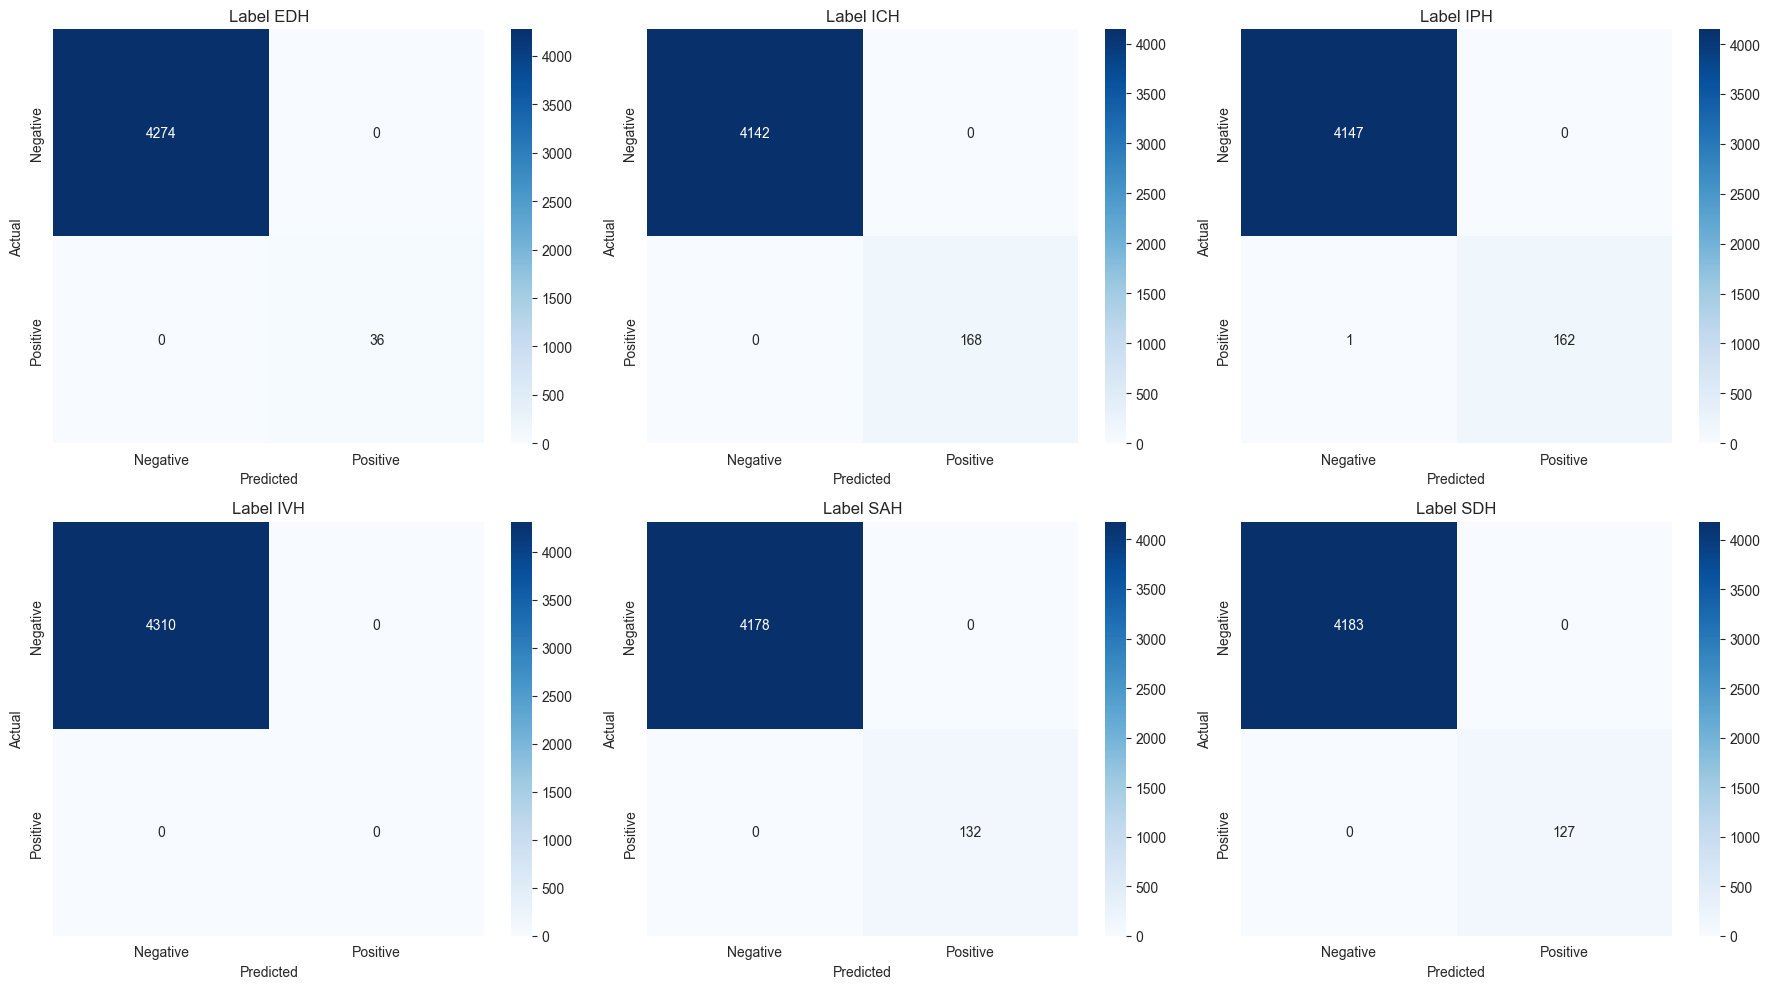

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(18, 10))

# Number of labels to plot (assumes conf_matrices is a list of matrices, one for each label)
num_labels = conf_matrices.shape[0]
injury = ['EDH','ICH','IPH','IVH',"SAH",'SDH']
for i in range(num_labels):
    plt.subplot(2, 3, i+1)  # Adjust subplot grid parameters depending on num_labels
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Label {injury[i]}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

#### VGG

In [46]:
vgg = models.vgg16(pretrained=True)
num_classes = 6
vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, num_classes)
vgg.features[0] = nn.Conv2d(4, 64, kernel_size=3, stride=1, padding=1)
vgg = vgg.to(device)

In [47]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=0.001)

Epoch [1/10], currBatch: 0/539, Loss: 0.9645
Epoch [1/10], currBatch: 1/539, Loss: 1.2311
Epoch [1/10], currBatch: 2/539, Loss: 0.4695
Epoch [1/10], currBatch: 3/539, Loss: 0.0000
Epoch [1/10], currBatch: 4/539, Loss: 4.9813
Epoch [1/10], currBatch: 5/539, Loss: 0.7954
Epoch [1/10], currBatch: 6/539, Loss: 0.0000
Epoch [1/10], currBatch: 7/539, Loss: 25.9483
Epoch [1/10], currBatch: 8/539, Loss: 0.1559
Epoch [1/10], currBatch: 9/539, Loss: 0.0939
Epoch [1/10], currBatch: 10/539, Loss: 0.0652
Epoch [1/10], currBatch: 11/539, Loss: 1.1129
Epoch [1/10], currBatch: 12/539, Loss: 0.2514
Epoch [1/10], currBatch: 13/539, Loss: 0.2256
Epoch [1/10], currBatch: 14/539, Loss: 0.2117
Epoch [1/10], currBatch: 15/539, Loss: 0.0001
Epoch [1/10], currBatch: 16/539, Loss: 1.0629
Epoch [1/10], currBatch: 17/539, Loss: 0.0113
Epoch [1/10], currBatch: 18/539, Loss: 0.1114
Epoch [1/10], currBatch: 19/539, Loss: 0.1874
Epoch [1/10], currBatch: 20/539, Loss: 0.3375
Epoch [1/10], currBatch: 21/539, Loss: 0.11

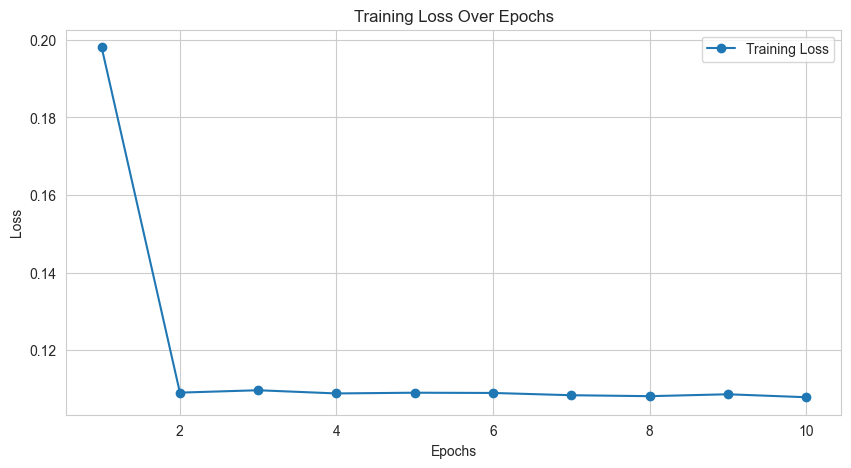

In [48]:
num_epochs = 10

train_loss_history = []  
for epoch in range(num_epochs):
    running_loss = 0.0
    for i,(images, labels) in enumerate(train_loader):
        images = images.to(device)
        images = images.permute(0, 3, 1, 2)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = vgg(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], currBatch: {i}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(train_loader)
    train_loss_history.append(epoch_loss) 
    torch.save(vgg.state_dict(), 'HeyCTModelDL_VGG.pth')
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}')

# Plotting the loss curve after training
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, marker='o', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
import torch
import numpy as np
from sklearn.metrics import f1_score, multilabel_confusion_matrix

vgg.eval()
total = 0
correct = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        images = images.permute(0, 3, 1, 2)
        labels = labels.to(device)

        outputs = torch.sigmoid(vgg(images))  # Convert logits to probabilities
        predicted = (outputs >= 0.5).float()  # Threshold predictions

        total += labels.numel()  # Total number of label entries
        correct += (predicted == labels).sum().item()  # Count correct predictions
        
        all_labels.append(labels.cpu().numpy())  # Store true labels
        all_predictions.append(predicted.cpu().numpy())  # Store predictions

# Concatenate all batches' labels and predictions
all_labels = np.vstack(all_labels)
all_labels = np.where(all_labels >= 0.5, 1, 0)

all_predictions = np.vstack(all_predictions)

# Calculate F1 score for each label
f1_scores = f1_score(all_labels, all_predictions, average=None)  # None to calculate for each label
average_f1_score = f1_score(all_labels, all_predictions, average='macro')  # 'macro' for unweighted mean

# Calculate confusion matrices for each label
conf_matrices = multilabel_confusion_matrix(all_labels, all_predictions)

# Print the results
print(f"Accuracy on Test Set: {correct / total * 100:.2f}%")
print(f"F1 Scores per label: {f1_scores}")
print(f"Average F1 Score: {average_f1_score}")
print("Confusion Matrices:")
for i, matrix in enumerate(conf_matrices):
    print(f"Label {i}:")
    print(matrix)

Accuracy on Test Set: 97.72%
F1 Scores per label: [0. 0. 0. 0. 0. 0.]
Average F1 Score: 0.0
Confusion Matrices:
Label 0:
[[4281    0]
 [  29    0]]
Label 1:
[[4161    0]
 [ 149    0]]
Label 2:
[[4164    0]
 [ 146    0]]
Label 3:
[[4310    0]
 [   0    0]]
Label 4:
[[4190    0]
 [ 120    0]]
Label 5:
[[4193    0]
 [ 117    0]]


C:\Users\Admin\PycharmProjects\TestProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\PycharmProjects\TestProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### GoogleNet

In [60]:
ggn = models.googlenet(pretrained=True)
ggn.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
ggn.fc = nn.Linear(ggn.fc.in_features, 6)

if hasattr(ggn, 'AuxLogits'):
    ggn.AuxLogits.fc = nn.Linear(ggn.AuxLogits.fc.in_features, num_classes)

ggn = ggn.to(device)

Epoch [1/10], currBatch: 0/539, Loss: 0.2028
Epoch [1/10], currBatch: 1/539, Loss: 0.2368
Epoch [1/10], currBatch: 2/539, Loss: 0.1501
Epoch [1/10], currBatch: 3/539, Loss: 0.1228
Epoch [1/10], currBatch: 4/539, Loss: 0.0579
Epoch [1/10], currBatch: 5/539, Loss: 0.0381
Epoch [1/10], currBatch: 6/539, Loss: 0.0726
Epoch [1/10], currBatch: 7/539, Loss: 0.0220
Epoch [1/10], currBatch: 8/539, Loss: 0.1641
Epoch [1/10], currBatch: 9/539, Loss: 0.0132
Epoch [1/10], currBatch: 10/539, Loss: 0.0123
Epoch [1/10], currBatch: 11/539, Loss: 0.0100
Epoch [1/10], currBatch: 12/539, Loss: 0.0081
Epoch [1/10], currBatch: 13/539, Loss: 0.0774
Epoch [1/10], currBatch: 14/539, Loss: 0.0059
Epoch [1/10], currBatch: 15/539, Loss: 0.0903
Epoch [1/10], currBatch: 16/539, Loss: 0.0066
Epoch [1/10], currBatch: 17/539, Loss: 0.2201
Epoch [1/10], currBatch: 18/539, Loss: 0.0930
Epoch [1/10], currBatch: 19/539, Loss: 0.1021
Epoch [1/10], currBatch: 20/539, Loss: 0.0727
Epoch [1/10], currBatch: 21/539, Loss: 0.118

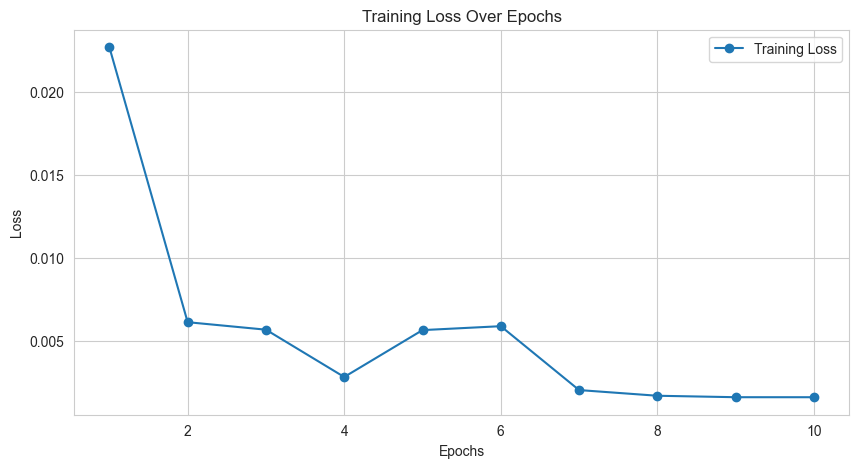

In [62]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(ggn.parameters(), lr=0.001)
num_epochs = 10

train_loss_history = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        images = images.permute(0, 3, 1, 2)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = ggn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f'Epoch [{epoch + 1}/{num_epochs}], currBatch: {i}/{len(train_loader)}, Loss: {loss.item():.4f}')

    epoch_loss = running_loss / len(train_loader)
    train_loss_history.append(epoch_loss)
    torch.save(ggn.state_dict(), 'HeyCTModelDL_GGN.pth')

    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {epoch_loss:.4f}')

# Plotting the loss curve after training
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, marker='o', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [63]:
import torch
import numpy as np
from sklearn.metrics import f1_score, multilabel_confusion_matrix

ggn.eval()
total = 0
correct = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        images = images.permute(0, 3, 1, 2)
        labels = labels.to(device)

        outputs = torch.sigmoid(ggn(images))  # Convert logits to probabilities
        predicted = (outputs >= 0.5).float()  # Threshold predictions

        total += labels.numel()  # Total number of label entries
        correct += (predicted == labels).sum().item()  # Count correct predictions
        
        all_labels.append(labels.cpu().numpy())  # Store true labels
        all_predictions.append(predicted.cpu().numpy())  # Store predictions

# Concatenate all batches' labels and predictions
all_labels = np.vstack(all_labels)
all_labels = np.where(all_labels >= 0.5, 1, 0)

all_predictions = np.vstack(all_predictions)

# Calculate F1 score for each label
f1_scores = f1_score(all_labels, all_predictions, average=None)  # None to calculate for each label
average_f1_score = f1_score(all_labels, all_predictions, average='macro')  # 'macro' for unweighted mean

# Calculate confusion matrices for each label
conf_matrices = multilabel_confusion_matrix(all_labels, all_predictions)

# Print the results
print(f"Accuracy on Test Set: {correct / total * 100:.2f}%")
print(f"F1 Scores per label: {f1_scores}")
print(f"Average F1 Score: {average_f1_score}")
print("Confusion Matrices:")
for i, matrix in enumerate(conf_matrices):
    print(f"Label {i}:")
    print(matrix)

Accuracy on Test Set: 99.78%
F1 Scores per label: [1.         1.         0.99310345 0.         1.         1.        ]
Average F1 Score: 0.8321839080459771
Confusion Matrices:
Label 0:
[[4281    0]
 [   0   29]]
Label 1:
[[4161    0]
 [   0  149]]
Label 2:
[[4164    0]
 [   2  144]]
Label 3:
[[4310    0]
 [   0    0]]
Label 4:
[[4190    0]
 [   0  120]]
Label 5:
[[4193    0]
 [   0  117]]


C:\Users\Admin\PycharmProjects\TestProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\PycharmProjects\TestProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


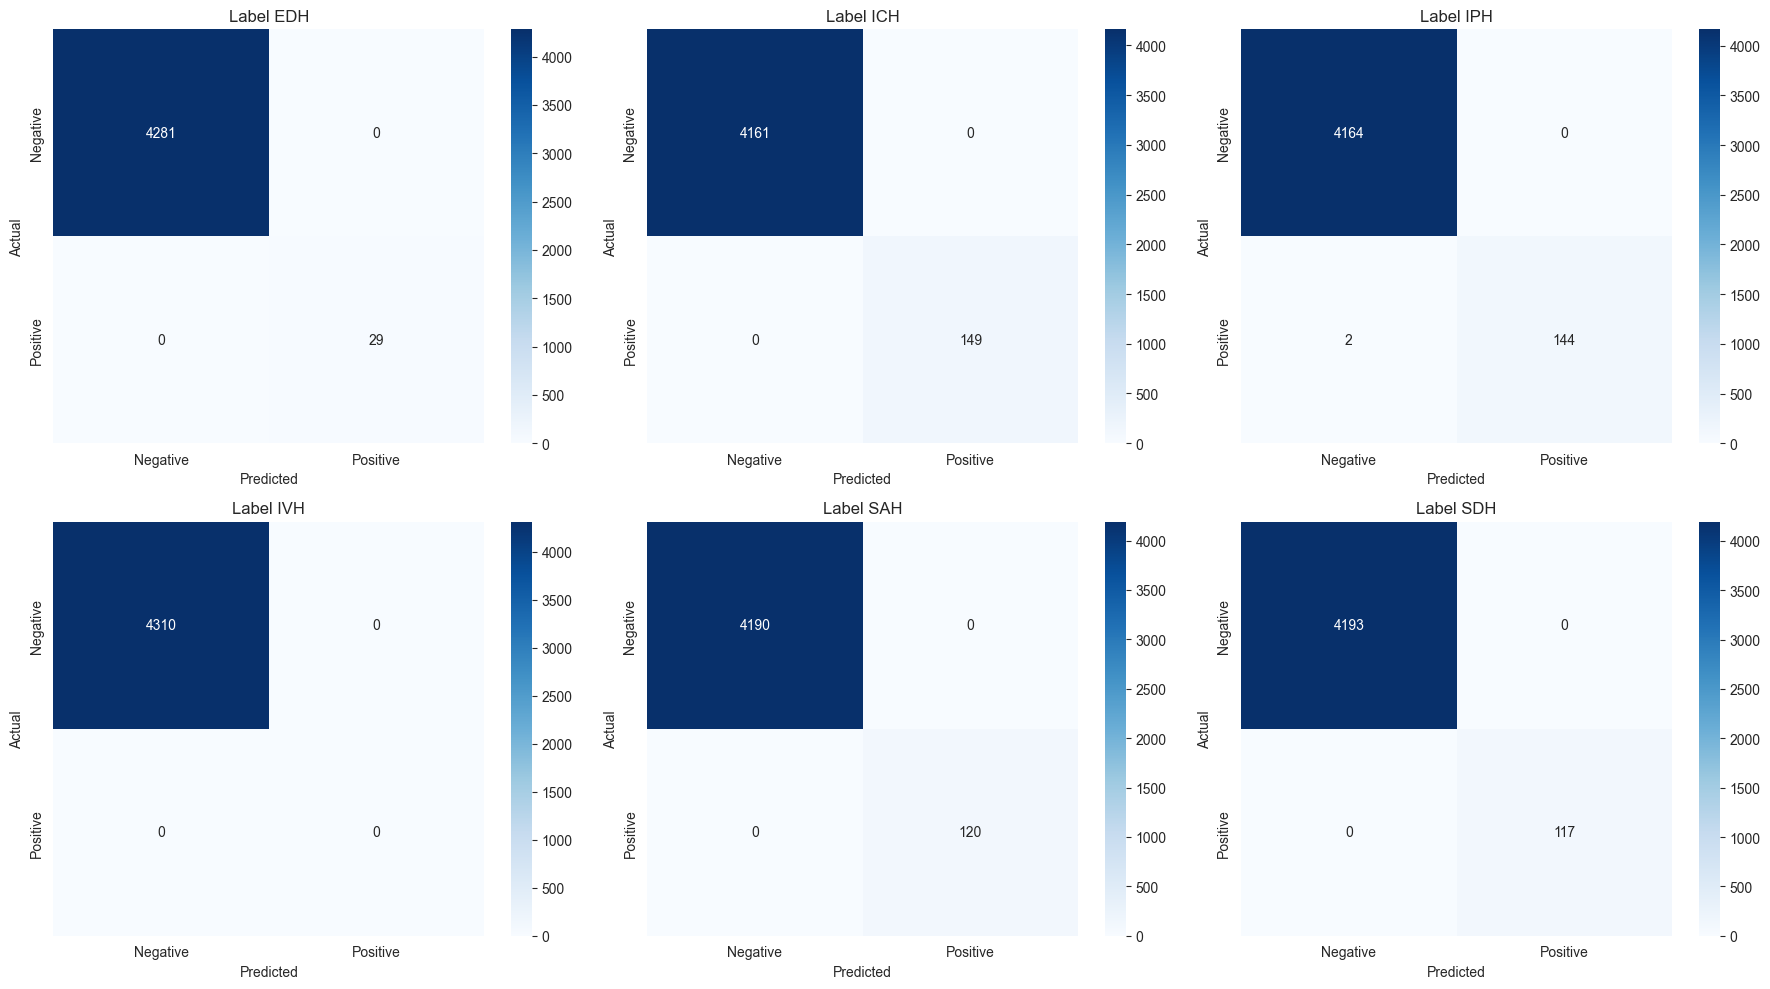

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(18, 10))

# Number of labels to plot (assumes conf_matrices is a list of matrices, one for each label)
num_labels = conf_matrices.shape[0]
injury = ['EDH','ICH','IPH','IVH',"SAH",'SDH']
for i in range(num_labels):
    plt.subplot(2, 3, i+1)  # Adjust subplot grid parameters depending on num_labels
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Label {injury[i]}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

#### Feature Extraction

In [7]:
# Load GoogleNet model
ggn = models.googlenet(pretrained=True)
ggn.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
ggn.fc = nn.Linear(ggn.fc.in_features, 6)

if hasattr(ggn, 'AuxLogits'):
    ggn.AuxLogits.fc = nn.Linear(ggn.AuxLogits.fc.in_features, num_classes)

ggn = ggn.to(device)

state_dict = torch.load('HeyCTModelDL_GGN.pth', map_location=device, weights_only=True)
ggn.load_state_dict(state_dict, strict=False)
ggn.fc = nn.Identity()  
ggn.eval() 

# Load ResNet model
res = models.resnet18(pretrained=True)
# Modify the first convolutional layer to have 1 input channel if using grayscale images
res.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
res.conv1 = res.conv1.to(device)  # Move the new conv1 layer to GPU

# Modify the fully connected output layer to match the number of classes (6 in this case)
res.fc = nn.Linear(res.fc.in_features, 6)
res.fc = res.fc.to(device)  # Move the new fc layer to GPU

# Move the entire model to the appropriate device (GPU or CPU)
res = res.to(device)

state_dict = torch.load('HeyCTModelDL_Seg.pth', map_location=device, weights_only=True)
res.load_state_dict(state_dict, strict=False)
res.fc = nn.Identity()  
res.eval()

C:\Users\Admin\PycharmProjects\TestProject\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Admin\PycharmProjects\TestProject\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Admin\PycharmProjects\TestProject\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. 

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [79]:
def extract_features(image, googlenet, resnet18):
    # Ensure models are in evaluation mode
    googlenet.eval()
    resnet18.eval()
    
    # Pass the image through GoogleNet
    with torch.no_grad():
        ggn_features = googlenet(image)  # Feature vector from GoogleNet
        
    # Pass the image through ResNet18
    with torch.no_grad():
        resnet_features = resnet18(image)  # Feature vector from ResNet18
        
    return ggn_features, resnet_features

#### Concatenating Features

In [80]:
def combine_features(ggn_features, resnet_features):
    combined_features = torch.cat((ggn_features, resnet_features), dim=1)
    return combined_features

In [81]:
import pandas as pd
print("data start")
dataset = ScanDataset(root_dir= processed_scans_path, csv_file="weighted.csv")
print("data generated")
# Calculate split sizes
total_count = len(dataset)
train_count = int(0.8 * total_count)
test_count = total_count - train_count

# Perform random split
train_dataset, test_dataset = random_split(dataset, [train_count, test_count])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
for images, labels in train_loader:
    # Example processing step
    print(images.shape, labels.shape)
    break
    

data start
data generated
torch.Size([1, 512, 512, 4]) torch.Size([1, 6])


In [82]:
all_features = []
all_labels = []
for images, labels in train_loader:
    images = images.to(device)
    images = images.permute(0, 3, 1, 2)
    
    # Extract and combine features
    ggn_features, resnet_features = extract_features(images, ggn, res)
    combined_features = combine_features(ggn_features, resnet_features)
    all_labels.append(labels)
    
    all_features.append(combined_features.cpu().detach().numpy())
print(len(all_features))

17237


In [83]:
all_features = np.squeeze(np.array(all_features), axis=1)
all_labels = np.squeeze(np.array(all_labels), axis=1)
all_labels = np.where(all_labels >= 0.5, 1, 0)

#### Optimiser

In [84]:
import numpy as np
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.special import gamma  # Import gamma from scipy.special

# Function for fitness evaluation (KNN classification accuracy)
def evaluate_fitness(X, y, selected_features):
    # Select only the features chosen by the agent
    if len(selected_features) == 0:
        return 0.0
    
    X_selected = X[:, selected_features]
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    # Train KNN classifier
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    
    # Evaluate accuracy
    y_pred = knn.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Lévy flight step calculation


def levy_flight(L):
    beta = 1.5
    # Correct calculation of sigma using scipy.special.gamma
    sigma = (gamma(1 + beta) * np.sin(np.pi * beta / 2) / 
             (gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, size=(L,))
    v = np.random.normal(0, 1, size=(L,))
    step = u / (np.abs(v) ** (1 / beta))
    return step

# DWSCSO Algorithm Implementation
def dwscso(X, y, population_size=100, max_iterations=100, num_features=None):
    # Initialize population (random feature subsets)
    if num_features is None:
        num_features = X.shape[1]
    population = [np.random.choice([0, 1], size=num_features) for _ in range(population_size)]
    fitness = [evaluate_fitness(X, y, np.where(agent == 1)[0]) for agent in population]
    
    # Initialize dynamic parameters
    best_agent = population[np.argmax(fitness)]
    best_fitness = max(fitness)
    WWDF = 1.0  # Water wave dynamic factor
    rG = 2.0  # Global sensitivity parameter

    # Main loop
    for t in range(max_iterations):
        for i in range(population_size):
            r = rG * random.random()  # Exploration parameter
            alpha = np.deg2rad(random.uniform(0, 360))  # Random angle
            
            if abs(rG) > 1:  # Exploration phase
                step = WWDF * r * np.cos(alpha) * random.uniform(0, 1)
                new_position = population[i] + step
            else:  # Exploitation phase
                step = levy_flight(num_features)
                new_position = population[i] + step * (best_agent - population[i])
            
            # Ensure binary feature subset representation
            new_position = np.clip(new_position, 0, 1)
            new_agent = (new_position > 0.5).astype(int)
            
             # Ensure at least 1 feature is selected
            if np.sum(new_agent) == 0:
                new_agent[random.randint(0, len(new_agent) - 1)] = 1
            
            # Evaluate new fitness
            new_fitness = evaluate_fitness(X, y, np.where(new_agent == 1)[0])
            
            # Update agent's position if new fitness is better
            if new_fitness > fitness[i]:
                population[i] = new_agent
                fitness[i] = new_fitness
            
            # Update global best
            if new_fitness > best_fitness:
                best_agent = new_agent
                best_fitness = new_fitness
        
        # Update dynamic parameters
        rG = 2 * (1 - t / max_iterations)
        if t % 10 == 0:  # Adjust WWDF periodically
            WWDF *= 1.2
        print(best_fitness)
    
    # Return best feature subset and fitness
    return best_agent, best_fitness


X = all_features
y = all_labels

# Run DWSCSO
best_features, best_accuracy = dwscso(X, y)
print(f"Best Features: {np.where(best_features == 1)[0]}")
print(f"Best Accuracy: {best_accuracy}")

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Best Features: [   1    2    3    8   13   14   15   16   17   18   20   21   22   23
   24   25   26   28   29   31   33   36   38   40   43   50   51   52
   56   57   58   64   66   69   70   71   75   76   77   80   83   84
   85   86   87   88   90   93   94   95   96   97   98  100  101  105
  106  107  108  109  110  111  112  113  118  119  120  125  126  128
  130  136  139  141  143  144  145  146  150  151  153  154  156  157
  160  165  167  168  174  175  176  177  178  179  180  181  184  185
  186  187  189  193  194  198  201  204  205  209  212  217  219  220
  221  222  223  

In [85]:
all_features.shape

(17237, 1536)

In [86]:
len(np.where(best_features == 1)[0])

787

#### PRSCNN

In [101]:
class PRSCNN(nn.Module):
    def __init__(self, input_dim, num_classes=6):
        super(PRSCNN, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        
        # Fully Connected Layers
        flattened_size = 64 * 783  # Computed based on the above calculations
        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Conv1 + Activation
        x = self.conv1(x)
        x = F.relu(x)
        
        # Conv2 + Activation
        x = self.conv2(x)
        x = F.relu(x)
        
        # Flatten
        x = torch.flatten(x, start_dim=1)
        
        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

Epoch 1/10: 100%|██████████| 539/539 [02:45<00:00,  3.26it/s]


Epoch [1/10], Loss: 0.2010


Epoch 2/10: 100%|██████████| 539/539 [02:43<00:00,  3.29it/s]


Epoch [2/10], Loss: 0.1946


Epoch 3/10: 100%|██████████| 539/539 [02:43<00:00,  3.30it/s]


Epoch [3/10], Loss: 0.1944


Epoch 4/10: 100%|██████████| 539/539 [02:43<00:00,  3.30it/s]


Epoch [4/10], Loss: 0.1941


Epoch 5/10: 100%|██████████| 539/539 [02:43<00:00,  3.29it/s]


Epoch [5/10], Loss: 0.1942


Epoch 6/10: 100%|██████████| 539/539 [02:43<00:00,  3.30it/s]


Epoch [6/10], Loss: 0.1941


Epoch 7/10: 100%|██████████| 539/539 [02:43<00:00,  3.30it/s]


Epoch [7/10], Loss: 0.1941


Epoch 8/10: 100%|██████████| 539/539 [02:43<00:00,  3.30it/s]


Epoch [8/10], Loss: 0.1943


Epoch 9/10: 100%|██████████| 539/539 [02:43<00:00,  3.30it/s]


Epoch [9/10], Loss: 0.1941


Epoch 10/10: 100%|██████████| 539/539 [02:43<00:00,  3.29it/s]

Epoch [10/10], Loss: 0.1942
Training complete.


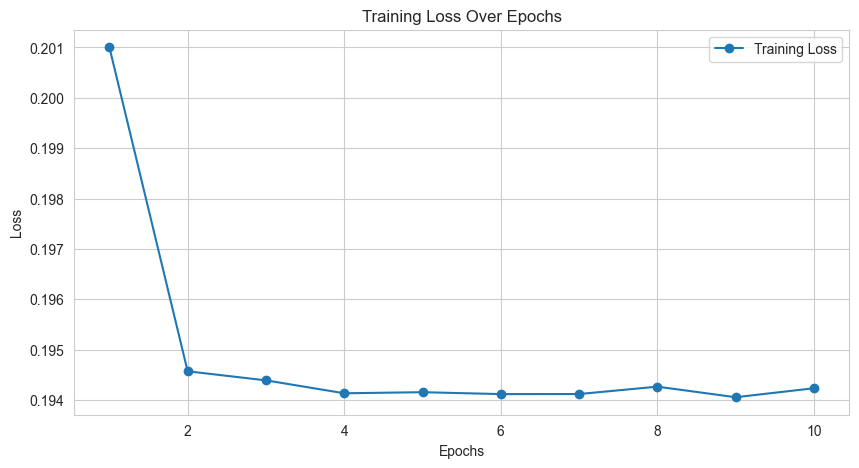

In [102]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm  # For a nice progress bar

# Initialize the PRSCNN model
model = PRSCNN(input_dim= 787, num_classes=6).to(device)

train_loss_history = []

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10  # Adjust as needed
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Iterate over batches
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images = images.to(device)
        labels = labels.to(device)

        # Preprocess and extract features
        images = images.permute(0, 3, 1, 2)  # Adjust to [N, C, H, W]
        ggn_features, resnet_features = extract_features(images, ggn, res)
        combined_features = combine_features(ggn_features, resnet_features)
        
        selected_features = combined_features[:, best_features == 1]
        selected_features = selected_features.unsqueeze(1)
        # Forward pass through PRSCNN
        outputs = model(selected_features)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss per epoch
    avg_loss = running_loss / len(train_loader)
    train_loss_history.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")


print("Training complete.") 
# Plotting the loss curve after training
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, marker='o', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()



In [114]:
import torch
import numpy as np
from sklearn.metrics import f1_score, multilabel_confusion_matrix

ggn.eval()
total = 0
correct = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        images = images.permute(0, 3, 1, 2)
        labels = labels.to(device)
        
        ggn_features, resnet_features = extract_features(images, ggn, res)
        combined_features = combine_features(ggn_features, resnet_features)
        
        selected_features = combined_features[:, best_features == 1]
        selected_features = selected_features.unsqueeze(1)
        # Forward pass through PRSCNN
        outputs = torch.sigmoid(model(selected_features))
        predicted = (outputs >= 0.5).float()  # Threshold predictions

        total += labels.numel()  # Total number of label entries
        correct += (predicted == labels).sum().item()  # Count correct predictions
        
        all_labels.append(labels.cpu().numpy())  # Store true labels
        all_predictions.append(predicted.cpu().numpy())  # Store predictions

# Concatenate all batches' labels and predictions
all_labels = np.vstack(all_labels)
all_labels = np.where(all_labels >= 0.5, 1, 0)

all_predictions = np.vstack(all_predictions)

# Calculate F1 score for each label
f1_scores = f1_score(all_labels, all_predictions, average=None)  # None to calculate for each label
average_f1_score = f1_score(all_labels, all_predictions, average='macro')  # 'macro' for unweighted mean

# Calculate confusion matrices for each label
conf_matrices = multilabel_confusion_matrix(all_labels, all_predictions)

# Print the results
print(f"Accuracy on Test Set: {correct / total * 100:.2f}%")
print(f"F1 Scores per label: {f1_scores}")
print(f"Average F1 Score: {average_f1_score}")
print("Confusion Matrices:")
for i, matrix in enumerate(conf_matrices):
    print(f"Label {i}:")
    print(matrix)

Accuracy on Test Set: 99.74%
F1 Scores per label: [1.         1.         0.99319728 1.         1.        ]
Average F1 Score: 0.9986394557823128
Confusion Matrices:
Label 0:
[[4277    0]
 [   0   33]]
Label 1:
[[4158    0]
 [   0  152]]
Label 2:
[[4162    0]
 [   2  146]]
Label 3:
[[4310    0]
 [   0    0]]
Label 4:
[[4191    0]
 [   0  119]]
Label 5:
[[4195    0]
 [   0  115]]


C:\Users\Admin\PycharmProjects\TestProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\PycharmProjects\TestProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


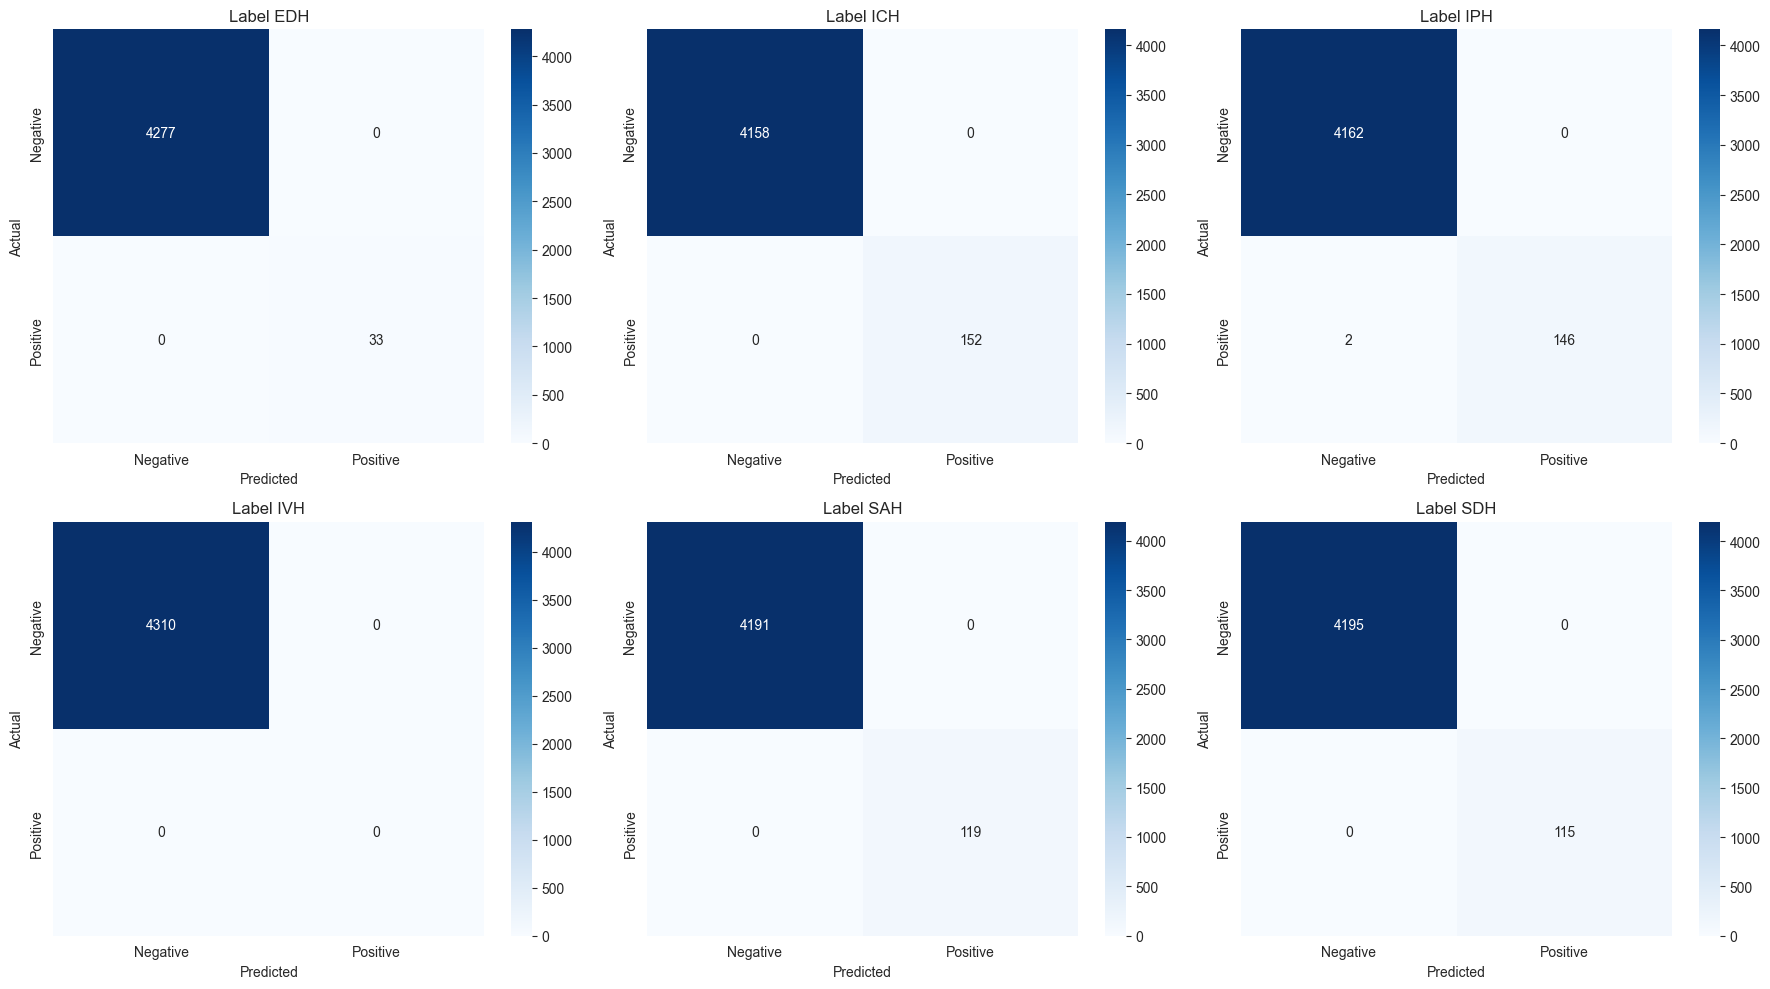

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(18, 10))

# Number of labels to plot (assumes conf_matrices is a list of matrices, one for each label)
num_labels = conf_matrices.shape[0]
injury = ['EDH','ICH','IPH','IVH',"SAH",'SDH']
for i in range(num_labels):
    plt.subplot(2, 3, i+1)  # Adjust subplot grid parameters depending on num_labels
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Label {injury[i]}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plt.tight_layout()
plt.show()